類別對應：{'back': 0, 'bad': 1, 'good': 2}
Epoch 1/80 | Train Loss: 1.2287, Train Acc: 46.99% | Val Loss: 1.0988, Val Acc: 20.55%
Epoch 2/80 | Train Loss: 0.9706, Train Acc: 54.98% | Val Loss: 1.0550, Val Acc: 48.97%
✅ 驗證準確度提升: 20.55% → 48.97%，重置早停計數器
Epoch 3/80 | Train Loss: 0.8665, Train Acc: 60.31% | Val Loss: 1.0266, Val Acc: 48.97%
⚠️ 早停計數器: 1/16
Epoch 4/80 | Train Loss: 0.7819, Train Acc: 65.81% | Val Loss: 0.9724, Val Acc: 50.34%
✅ 驗證準確度提升: 48.97% → 50.34%，重置早停計數器
Epoch 5/80 | Train Loss: 0.7011, Train Acc: 68.81% | Val Loss: 0.9196, Val Acc: 50.34%
⚠️ 早停計數器: 1/16
Epoch 6/80 | Train Loss: 0.6514, Train Acc: 74.14% | Val Loss: 0.8416, Val Acc: 62.33%
✅ 驗證準確度提升: 50.34% → 62.33%，重置早停計數器
Epoch 7/80 | Train Loss: 0.6014, Train Acc: 74.40% | Val Loss: 0.7656, Val Acc: 59.59%
⚠️ 早停計數器: 1/16
Epoch 8/80 | Train Loss: 0.5595, Train Acc: 76.89% | Val Loss: 0.6909, Val Acc: 71.23%
✅ 驗證準確度提升: 62.33% → 71.23%，重置早停計數器
Epoch 9/80 | Train Loss: 0.5257, Train Acc: 79.90% | Val Loss: 0.6577, Val Acc: 7

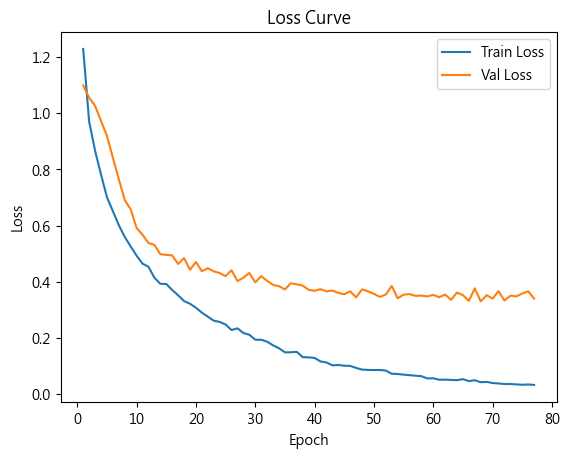

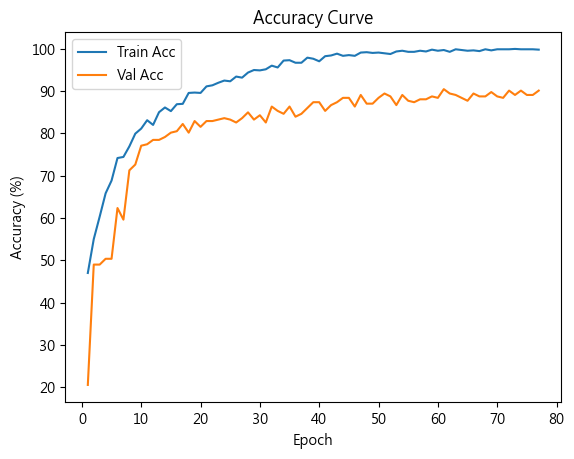

分類報告：
               precision    recall  f1-score   support

        back       0.91      0.99      0.95       143
         bad       0.93      0.73      0.82        89
        good       0.85      0.93      0.89        60

    accuracy                           0.90       292
   macro avg       0.90      0.89      0.89       292
weighted avg       0.90      0.90      0.90       292



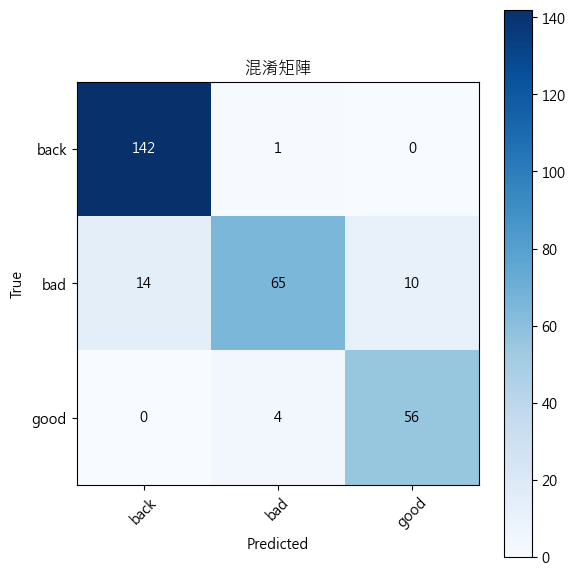

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Microsoft JhengHei'  # 微軟正黑體，支援繁體中文
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import torchvision.transforms.functional as TF



# 1. EarlyStopping 類別
class EarlyStopping:
    def __init__(self, patience=16, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, acc, model):
        if self.best_acc is None or acc > self.best_acc + self.delta:
            if self.verbose and self.best_acc is not None:
                print(f"✅ 驗證準確度提升: {self.best_acc:.2f}% → {acc:.2f}%，重置早停計數器")
            self.best_acc = acc
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"⚠️ 早停計數器: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# 2. 模型選取函數，方便更換模型
def get_model(model_name, num_classes, img_size):
    if model_name == 'resnet18':
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'convnext_tiny':
        model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == 'custom':
        class CustomCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                    nn.MaxPool2d(2)
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
                    nn.ReLU(), nn.Dropout(0.5),
                    nn.Linear(256, num_classes)
                )
            def forward(self, x):
                x = self.features(x)
                return self.classifier(x)
        model = CustomCNN()
    elif model_name == 'ultrafast':
        class UltraFastCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=1),  # [B, 3, 128,128] -> [B, 8, 64,64]
                    nn.ReLU(),

                    nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=1),  # [B, 16, 32,32]
                    nn.ReLU(),

                    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [B, 32, 16,16]
                    nn.ReLU(),

                    nn.AdaptiveAvgPool2d((1, 1))  # → [B, 32, 1, 1]
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),         # → [B, 32]
                    nn.Linear(32, num_classes)  # 最少參數
                )

            def forward(self, x):
                x = self.features(x)
                return self.classifier(x)

        model = UltraFastCNN()
    else:
        raise ValueError(f"未知模型: {model_name}")
    return model

# 3. 單 epoch 訓練與驗證
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100 * correct / total

# 4. 繪製訓練曲線
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
    plt.legend(); plt.show()

# 5. 評估並印出分類報告與混淆矩陣
def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print("分類報告：\n", classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('混淆矩陣'); plt.colorbar()
    ticks = range(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)
    thresh = cm.max() / 2
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout(); plt.show()

def pad_to_square(img, fill=0):
    w, h = img.size
    if w == h:
        return img
    diff = abs(h - w)
    pad1, pad2 = diff // 2, diff - diff // 2
    return TF.pad(img, (0, pad1, 0, pad2) if h < w else (pad1, 0, pad2, 0), fill=fill)

# 6. 主流程
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset_path = "corp_augmented_data"
    batch_size, img_size = 256, 128
    num_epochs, lr = 80, 5e-5
    model_name = 'custom'  # 可選 'resnet18', 'convnext_tiny', 'custom' ultrafast

    # 資料預處理與載入
    transform = transforms.Compose([
        transforms.Lambda(lambda img: pad_to_square(img, fill=0)),   # 保持比例 pad 成正方形
        transforms.Resize((img_size, img_size)),                     # 再縮放成模型大小
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])


    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    num_classes = len(dataset.classes)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
    print(f"類別對應：{dataset.class_to_idx}")

    # 建立模型、損失函數、優化器與早停
    model = get_model(model_name, num_classes, img_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopping(patience=16, verbose=True)

    # 紀錄歷史
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # 訓練迴圈
    for epoch in range(1, num_epochs+1):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(model, test_loader, criterion, device)
        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.2f}% | "
              f"Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.2f}%")
        history['train_loss'].append(t_loss); history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss); history['val_acc'].append(v_acc)

        early_stopper(v_acc, model)
        if early_stopper.early_stop:
            print("🛑 觸發早停，停止訓練")
            break

    # 儲存最佳模型
    best_path = f"{model_name}_best_model.pth"
    torch.save(early_stopper.best_model_state, best_path)
    print(f"✅ 已儲存最佳模型：{best_path}")

    # 繪製訓練曲線
    plot_metrics(history)

    # 印出分類報告與混淆矩陣
    evaluate_model(model, test_loader, device, dataset.classes)

if __name__ == "__main__":
    main()


類別對應：{'bad': 0, 'good': 1}
Epoch 1/80 | Train Loss: 0.7842, Train Acc: 56.06% | Val Loss: 0.6923, Val Acc: 53.85%
Epoch 2/80 | Train Loss: 0.6987, Train Acc: 60.98% | Val Loss: 0.6823, Val Acc: 57.34%
✅ 驗證準確度提升: 53.85% → 57.34%，重置早停計數器
Epoch 3/80 | Train Loss: 0.6296, Train Acc: 65.03% | Val Loss: 0.6947, Val Acc: 43.36%
⚠️ 早停計數器: 1/16
Epoch 4/80 | Train Loss: 0.6096, Train Acc: 64.50% | Val Loss: 0.6899, Val Acc: 51.75%
⚠️ 早停計數器: 2/16
Epoch 5/80 | Train Loss: 0.5544, Train Acc: 72.58% | Val Loss: 0.6708, Val Acc: 65.03%
✅ 驗證準確度提升: 57.34% → 65.03%，重置早停計數器
Epoch 6/80 | Train Loss: 0.5725, Train Acc: 69.24% | Val Loss: 0.6720, Val Acc: 62.24%
⚠️ 早停計數器: 1/16
Epoch 7/80 | Train Loss: 0.5064, Train Acc: 75.04% | Val Loss: 0.6776, Val Acc: 55.94%
⚠️ 早停計數器: 2/16
Epoch 8/80 | Train Loss: 0.5079, Train Acc: 75.04% | Val Loss: 0.6441, Val Acc: 67.13%
✅ 驗證準確度提升: 65.03% → 67.13%，重置早停計數器
Epoch 9/80 | Train Loss: 0.4575, Train Acc: 80.14% | Val Loss: 0.6194, Val Acc: 69.23%
✅ 驗證準確度提升: 67.13% → 69.23

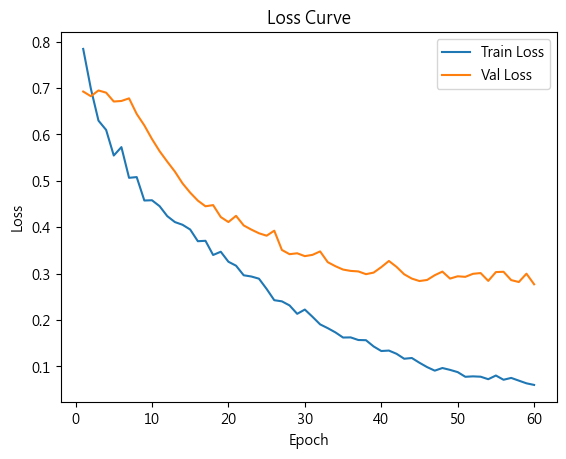

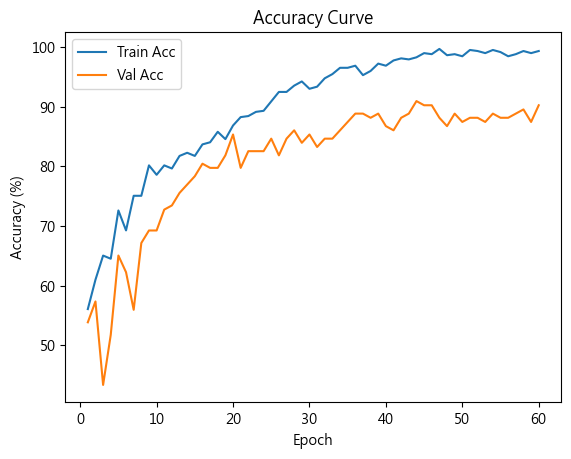

分類報告：
               precision    recall  f1-score   support

         bad       0.93      0.90      0.91        82
        good       0.87      0.90      0.89        61

    accuracy                           0.90       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143



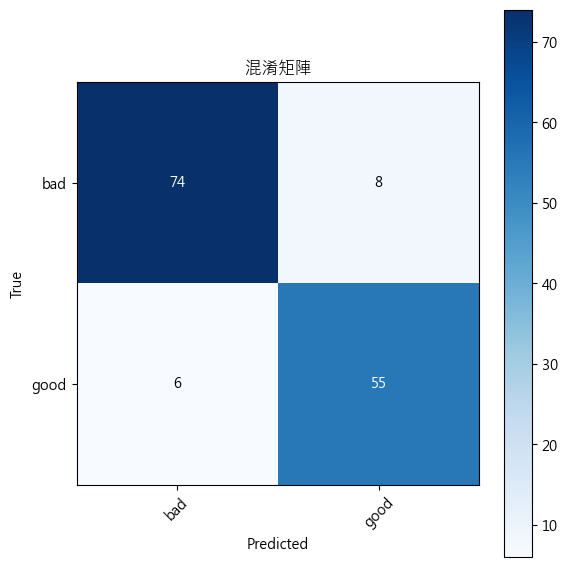

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Microsoft JhengHei'  # 微軟正黑體，支援繁體中文
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import torchvision.transforms.functional as TF



# 1. EarlyStopping 類別
class EarlyStopping:
    def __init__(self, patience=16, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, acc, model):
        if self.best_acc is None or acc > self.best_acc + self.delta:
            if self.verbose and self.best_acc is not None:
                print(f"✅ 驗證準確度提升: {self.best_acc:.2f}% → {acc:.2f}%，重置早停計數器")
            self.best_acc = acc
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"⚠️ 早停計數器: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# 2. 模型選取函數，方便更換模型
def get_model(model_name, num_classes, img_size):
    if model_name == 'resnet18':
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'convnext_tiny':
        model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == 'custom':
        class CustomCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                    nn.MaxPool2d(2)
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
                    nn.ReLU(), nn.Dropout(0.5),
                    nn.Linear(256, num_classes)
                )
            def forward(self, x):
                x = self.features(x)
                return self.classifier(x)
        model = CustomCNN()
    elif model_name == 'ultrafast':
        class UltraFastCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=1),  # [B, 3, 128,128] -> [B, 8, 64,64]
                    nn.ReLU(),

                    nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=1),  # [B, 16, 32,32]
                    nn.ReLU(),

                    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [B, 32, 16,16]
                    nn.ReLU(),

                    nn.AdaptiveAvgPool2d((1, 1))  # → [B, 32, 1, 1]
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),         # → [B, 32]
                    nn.Linear(32, num_classes)  # 最少參數
                )

            def forward(self, x):
                x = self.features(x)
                return self.classifier(x)

        model = UltraFastCNN()
    else:
        raise ValueError(f"未知模型: {model_name}")
    return model

# 3. 單 epoch 訓練與驗證
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100 * correct / total

# 4. 繪製訓練曲線
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
    plt.legend(); plt.show()

# 5. 評估並印出分類報告與混淆矩陣
def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print("分類報告：\n", classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('混淆矩陣'); plt.colorbar()
    ticks = range(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)
    thresh = cm.max() / 2
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout(); plt.show()

def pad_to_square(img, fill=0):
    w, h = img.size
    if w == h:
        return img
    diff = abs(h - w)
    pad1, pad2 = diff // 2, diff - diff // 2
    return TF.pad(img, (0, pad1, 0, pad2) if h < w else (pad1, 0, pad2, 0), fill=fill)

# 6. 主流程
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset_path = "corp_augmented_dataNoback"
    batch_size, img_size = 256, 128
    num_epochs, lr = 80, 5e-5
    model_name = 'custom'  # 可選 'resnet18', 'convnext_tiny', 'custom' ultrafast

    # 資料預處理與載入
    transform = transforms.Compose([
        transforms.Lambda(lambda img: pad_to_square(img, fill=0)),   # 保持比例 pad 成正方形
        transforms.Resize((img_size, img_size)),                     # 再縮放成模型大小
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])


    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    num_classes = len(dataset.classes)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
    print(f"類別對應：{dataset.class_to_idx}")

    # 建立模型、損失函數、優化器與早停
    model = get_model(model_name, num_classes, img_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopping(patience=16, verbose=True)

    # 紀錄歷史
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # 訓練迴圈
    for epoch in range(1, num_epochs+1):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(model, test_loader, criterion, device)
        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.2f}% | "
              f"Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.2f}%")
        history['train_loss'].append(t_loss); history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss); history['val_acc'].append(v_acc)

        early_stopper(v_acc, model)
        if early_stopper.early_stop:
            print("🛑 觸發早停，停止訓練")
            break

    # 儲存最佳模型
    best_path = f"{model_name}_Noback_best_model.pth"
    torch.save(early_stopper.best_model_state, best_path)
    print(f"✅ 已儲存最佳模型：{best_path}")

    # 繪製訓練曲線
    plot_metrics(history)

    # 印出分類報告與混淆矩陣
    evaluate_model(model, test_loader, device, dataset.classes)

if __name__ == "__main__":
    main()
